In [1]:
! pip install bayesian-optimization
! pip install lightgbm

  Using cached https://files.pythonhosted.org/packages/24/40/11b12af7f322c1e20446c037c47344d89bab4922b8859419d82cf56d796d/scipy-1.2.3-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/31/9f/042db462417451e81035c3d43b722e88450c628a33dfda69777a801b0d40/scikit_learn-0.20.4-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/3a/5f/47e578b3ae79e2624e205445ab77a1848acdaa2929a00eeef6b16eaaeb20/numpy-1.16.6-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/25/47/f8ef524e15ff86f5246cb4e1cee200b747ddb2536429fa021cc5f17ea40a/lightgbm-3.0.0-py2.py3-none-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/24/40/11b12af7f322c1e20446c037c47344d89bab4922b8859419d82cf56d796d/scipy-1.2.3-cp27-cp27mu-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/3a/5f/47e578b3ae79e2624e205445ab77a1848acdaa2929a00eeef6b16eaaeb20/numpy-1.16.6-cp27-cp27mu-

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import folium
import warnings
warnings.filterwarnings("ignore")
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from statsmodels.formula.api import *
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm 
from lightgbm import LGBMRegressor

In [3]:
# load data
data_final = pd.read_csv("data_200k_latest.csv")
data_final = data_final.iloc[:, 1:]
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   year           200000 non-null  int64  
 1   month          200000 non-null  int64  
 2   day            200000 non-null  int64  
 3   latitude       200000 non-null  float64
 4   longitude      200000 non-null  float64
 5   week_of_day    200000 non-null  int64  
 6   pack           200000 non-null  int64  
 7   city           200000 non-null  object 
 8   category       200000 non-null  int64  
 9   county_number  200000 non-null  int64  
 10  county         200000 non-null  object 
 11  store_num      200000 non-null  int64  
 12  item_number    200000 non-null  int64  
 13  bottle_volume  200000 non-null  int64  
 14  cost_price     200000 non-null  float64
 15  retail_price   200000 non-null  float64
 16  volume_sold    200000 non-null  float64
 17  store_number   200000 non-nul

In [4]:
data_final.describe()

,year,month,day,latitude,longitude,week_of_day,pack,category,county_number,store_num,item_number,bottle_volume,cost_price,retail_price,volume_sold,store_number,encoded_city,population
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,2015.024640,6.676015,15.812315,-93.010229,41.964581,2.623950,11.273535,1.045097e+06,56.766040,84.209260,45716.656830,943.375015,1.253180,2.691318,7.005908,3636.994595,189.944500,146720.847845
std,2.015258,3.440053,8.747605,1.645891,0.645199,1.253289,4.511890,5.771532e+04,27.599705,84.710017,49310.269337,455.577137,1.515264,2.723048,6.100439,960.194741,132.977488,159037.859991
min,2012.000000,1.000000,1.000000,-96.563230,40.400038,1.000000,1.000000,1.011100e+06,1.000000,1.000000,102.000000,20.000000,0.010000,0.010000,0.020000,2106.000000,0.000000,3645.000000
25%,2013.000000,4.000000,8.000000,-93.808855,41.561712,2.000000,6.000000,1.012300e+06,31.000000,16.000000,27783.000000,750.000000,0.370000,0.610000,2.000000,2614.000000,76.000000,21034.000000
50%,2015.000000,7.000000,16.000000,-93.106728,41.833351,3.000000,12.000000,1.031200e+06,61.000000,52.000000,38176.000000,750.000000,0.660000,1.390000,6.000000,3744.000000,140.000000,95155.000000
75%,2017.000000,10.000000,23.000000,-91.630677,42.489119,4.000000,12.000000,1.062310e+06,77.000000,145.000000,58875.000000,1000.000000,1.030000,4.250000,10.500000,4380.000000,304.000000,215462.000000
max,2018.000000,12.000000,31.000000,-90.182002,43.491139,6.000000,30.000000,1.901200e+06,99.000000,248.000000,995606.000000,6000.000000,6.610000,12.500000,36.000000,9931.000000,445.000000,487204.000000


In [5]:
# convert data types 
data_final["city"] = data_final["city"].astype("category")
data_final["category"] = data_final["category"].astype("category")
data_final["county_number"] = data_final["county_number"].astype("category")
data_final["item_number"] = data_final["item_number"].astype("category")
data_final["store_number"] = data_final["store_number"].astype("category")
data_final["encoded_city"] = data_final["encoded_city"].astype("category")
data_final.columns

Index(['year', 'month', 'day', 'latitude', 'longitude', 'week_of_day', 'pack',
       'city', 'category', 'county_number', 'county', 'store_num',
       'item_number', 'bottle_volume', 'cost_price', 'retail_price',
       'volume_sold', 'store_number', 'encoded_city', 'population'],
      dtype='object')

In [6]:
# train-test splitting 
X = data_final[['week_of_day', 'pack', 'store_num', 'bottle_volume', 
                'cost_price', 'retail_price', 'population', 'encoded_city',
                'category', 'county_number', 'store_number', 'item_number']]

y = data_final.volume_sold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

## Decision Tree

### Baseline performance

In [7]:
dt_model = DecisionTreeRegressor(max_depth=1, random_state= 100)
dt_model.fit(X_train, y_train)
pred = dt_model.predict(X_test)
dt_base_rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE: " + str(dt_base_rmse))
# tree.plot_tree(reg,feature_names= X_train.columns)

RMSE: 5.424713160374789


### Parameter Tuning

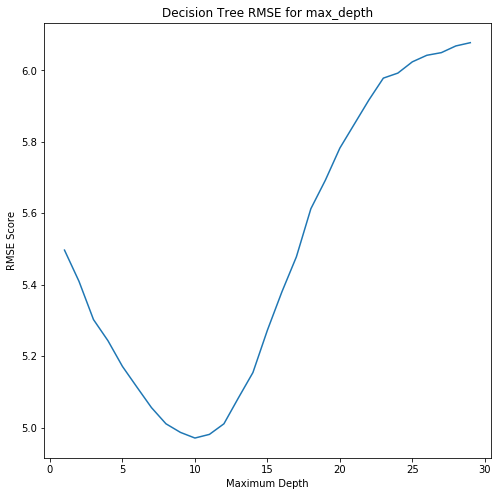

In [8]:
# Cursory search for max_depth hyperparameter
n_estimators_score = []
for i in range(1,30):
    cv_results = cross_validate(DecisionTreeRegressor(max_depth= i, random_state= 100), 
                                X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 3)
    n_estimators_score.append(-sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(range(1,30), n_estimators_score)
plt.title('Decision Tree RMSE for max_depth')
plt.xlabel('Maximum Depth')
plt.ylabel('RMSE Score')
plt.show()
fig.savefig('DT-max_depth_new.pdf')
plt.close()

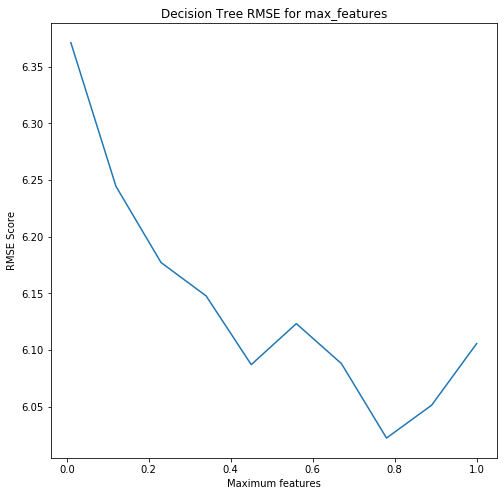

In [9]:
# Cursory search for max_features hyperparameter
n_estimators_score = []
for i in np.linspace(0.1, 1, 10):
    cv_results = cross_validate(DecisionTreeRegressor(max_features= i, random_state= 100), 
                                X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 3)
    n_estimators_score.append(-sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(np.linspace(0.01, 1, 10), n_estimators_score)
plt.title('Decision Tree RMSE for max_features')
plt.xlabel('Maximum features')
plt.ylabel('RMSE Score')
plt.show()
fig.savefig('DT-max_features_new.pdf')
plt.close()

In [10]:
# Decision Tree regressor tuning 
def dt_func(max_depth,max_features):
    cv_results = cross_validate(DecisionTreeRegressor(max_depth = int(max_depth), 
                                                           max_features = max_features
                                                           ,random_state= 100),
                                X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 3)
    return sum(cv_results['test_score']) / len(cv_results['test_score'])


# Find the global maximum of the target function 
dt_params = BayesianOptimization(dt_func, {'max_depth': (5,15), 'max_features': (0.6, 1)}, random_state = 100)
dt_params.maximize(n_iter = 10, init_points = 2)
final_para_dt = dt_params.max
dt_params.max

|   iter    |  target   | max_depth | max_fe... |
-------------------------------------------------
|  1        | -4.97     |  10.43    |  0.7113   |
|  2        | -4.986    |  9.245    |  0.9379   |
|  3        | -5.174    |  6.716    |  0.6092   |
|  4        | -5.083    |  13.27    |  1.0      |
|  5        | -5.238    |  15.0     |  0.6      |
|  6        | -4.981    |  11.63    |  1.0      |
|  7        | -4.971    |  10.27    |  1.0      |
|  8        | -5.0      |  11.31    |  0.6      |
|  9        | -5.022    |  9.739    |  0.6      |
|  10       | -5.171    |  5.0      |  1.0      |
|  11       | -5.011    |  8.296    |  1.0      |
|  12       | -4.971    |  10.91    |  1.0      |


{'target': -4.969565758498863,
 'params': {'max_depth': 10.434049417909655,
  'max_features': 0.7113477540375185}}

In [11]:
depth = int(final_para_dt['params']['max_depth'])
features = final_para_dt['params']['max_features']

dt_model = DecisionTreeRegressor(max_depth= depth,max_features = features,random_state= 100)
dt_model.fit(X_train, y_train)

pred = dt_model.predict(X_test)
print("max-depth: " + str(depth))
print("max-features: "+str(features))
dt_rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE: " + str(dt_rmse))

max-depth: 10
max-features: 0.7113477540375185
RMSE: 4.855998651241666


In [12]:
features = list(X.columns)
importance = list(dt_model.feature_importances_)
importance_dict = {}
for i in range(len(features)):
    importance_dict[features[i]] = importance[i]
sorted(importance_dict.items(), key = lambda item: abs(item[1]), reverse = True)

[('bottle_volume', 0.523958246935016),
 ('item_number', 0.12359883700100162),
 ('store_number', 0.07710985037227014),
 ('retail_price', 0.05854396160937547),
 ('store_num', 0.048768605233200604),
 ('cost_price', 0.04089461099920347),
 ('pack', 0.038979983292913675),
 ('population', 0.0304930935988949),
 ('category', 0.022184546508145126),
 ('encoded_city', 0.020191943507145572),
 ('county_number', 0.012107152354936649),
 ('week_of_day', 0.003169168587896802)]

## Random Forest

### Baseline performance

In [13]:
rf_model = RandomForestRegressor(n_estimators = 1, max_depth=1, random_state=100)
rf_model.fit(X_train, y_train)
rf_model_pred = rf_model.predict(X_test)
rf_base_rmse = np.sqrt(mean_squared_error(y_test, rf_model_pred))
print("RMSE: " + str(rf_base_rmse))

RMSE: 5.425776888698941


### Parameter Tuning

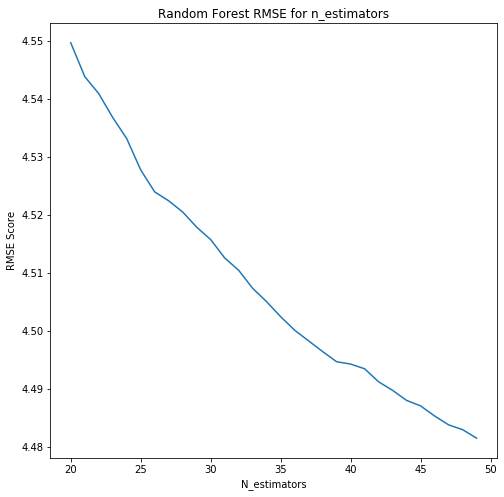

In [14]:
# Cursory search for n_estimators hyperparameter
n_estimators_score = []
for i in range(20,50):
    cv_results = cross_validate(RandomForestRegressor(n_estimators= i,random_state= 100), 
                                X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 3)
    n_estimators_score.append(-sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(range(20,50), n_estimators_score)
plt.title('Random Forest RMSE for n_estimators')
plt.xlabel('N_estimators')
plt.ylabel('RMSE Score')
plt.show()
fig.savefig('RF-n_estimators_new.pdf')
plt.close()

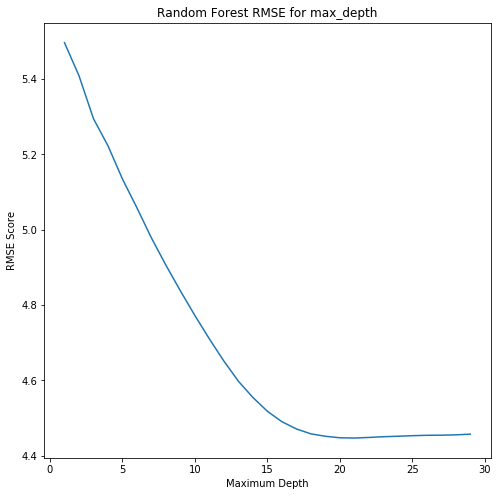

In [15]:
# Cursory search for max_depth hyperparameter
n_estimators_score = []
for i in range(1,30):
    cv_results = cross_validate(RandomForestRegressor(max_depth= i,random_state= 100), 
                                X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 3)
    n_estimators_score.append(-sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(range(1,30), n_estimators_score)
plt.title('Random Forest RMSE for max_depth')
plt.xlabel('Maximum Depth')
plt.ylabel('RMSE Score')
plt.show()
fig.savefig('RF-max_depth_new.pdf')
plt.close()

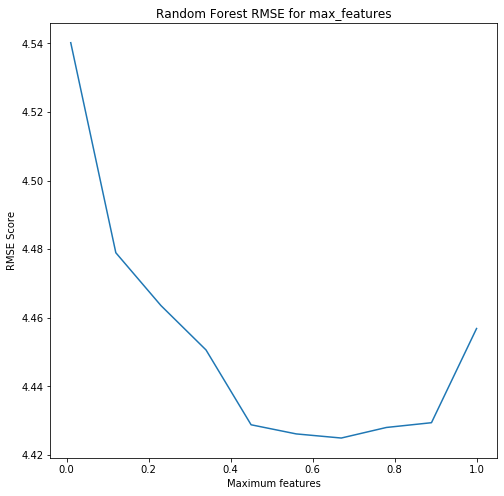

In [16]:
# Cursory search for max_features hyperparameter
n_estimators_score = []
for i in np.linspace(0.1, 1, 10):
    cv_results = cross_validate(RandomForestRegressor(max_features= i,random_state= 100), 
                                X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 3)
    n_estimators_score.append(-sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(np.linspace(0.01, 1, 10), n_estimators_score)
plt.title('Random Forest RMSE for max_features')
plt.xlabel('Maximum features')
plt.ylabel('RMSE Score')
plt.show()
fig.savefig('RF-max_features_new.pdf')
plt.close()

In [17]:
# Random Forest regressor tuning 
def rf_func(n_estimators,max_depth,max_features):
    cv_results = cross_validate(RandomForestRegressor(n_estimators= int(n_estimators),
                                                      max_depth = int(max_depth), 
                                                      max_features = max_features
                                                      ,random_state= 100),
                                X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 3)
    return sum(cv_results['test_score']) / len(cv_results['test_score'])


# Find the global maximum of the target function 
rf_params = BayesianOptimization(rf_func, {'n_estimators': (48,50), 'max_depth': (15,25), 'max_features': (0.4, 1)}, random_state = 100)
rf_params.maximize(n_iter = 10, init_points = 2)
final_para_rf = rf_params.max
rf_params.max

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        | -4.437    |  20.43    |  0.567    |  48.85    |
|  2        | -4.46     |  23.45    |  0.4028   |  48.24    |
|  3        | -4.438    |  20.47    |  0.6322   |  48.89    |
|  4        | -4.47     |  19.02    |  0.4      |  48.05    |
|  5        | -4.462    |  21.04    |  0.4      |  48.17    |
|  6        | -4.465    |  20.11    |  0.4      |  49.34    |
|  7        | -4.441    |  20.32    |  0.7694   |  48.58    |
|  8        | -4.453    |  23.92    |  0.4438   |  49.84    |
|  9        | -4.466    |  20.77    |  0.4      |  48.84    |
|  10       | -4.437    |  20.23    |  0.713    |  48.86    |
|  11       | -4.446    |  20.1     |  0.4301   |  48.62    |
|  12       | -4.456    |  20.38    |  0.9767   |  48.99    |


{'target': -4.436594062578714,
 'params': {'max_depth': 20.434049417909655,
  'max_features': 0.5670216310562777,
  'n_estimators': 48.849035181498266}}

In [18]:
estimators = int(final_para_rf['params']['n_estimators'])
depth = int(final_para_rf['params']['max_depth'])
features = final_para_rf['params']['max_features']

rf_model = RandomForestRegressor(n_estimators = estimators,max_depth = depth,max_features = features,random_state= 100)
rf_model.fit(X_train, y_train)

pred = rf_model.predict(X_test)
print("max-depth: " + str(depth))
print("max-features: "+str(features))
rf_rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE: " + str(rf_rmse))

max-depth: 20
max-features: 0.5670216310562777
RMSE: 4.29764790896443


In [19]:
features = list(X.columns)
importance = list(rf_model.feature_importances_)
importance_dict = {}
for i in range(len(features)):
    importance_dict[features[i]] = importance[i]
sorted(importance_dict.items(), key = lambda item: abs(item[1]), reverse = True)

[('bottle_volume', 0.2153829918424893),
 ('store_number', 0.1414187320430137),
 ('population', 0.10586413169237371),
 ('item_number', 0.09844574432277284),
 ('retail_price', 0.07655902570461907),
 ('cost_price', 0.07070051938238797),
 ('encoded_city', 0.06548243423094657),
 ('category', 0.05683482220389329),
 ('pack', 0.05110927769154205),
 ('store_num', 0.04297985783515991),
 ('county_number', 0.03970884352014329),
 ('week_of_day', 0.03551361953065839)]

## Light GBM

### Baseline performance

In [20]:
lgbm_model = LGBMRegressor(max_depth= 1,num_leaves = 2,random_state= 100)
lgbm_model.fit(X_train, y_train)

pred = lgbm_model.predict(X_test)
lgbm_base_rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE: " + str(lgbm_base_rmse))

RMSE: 4.776349545352471


### Parameter Tuning

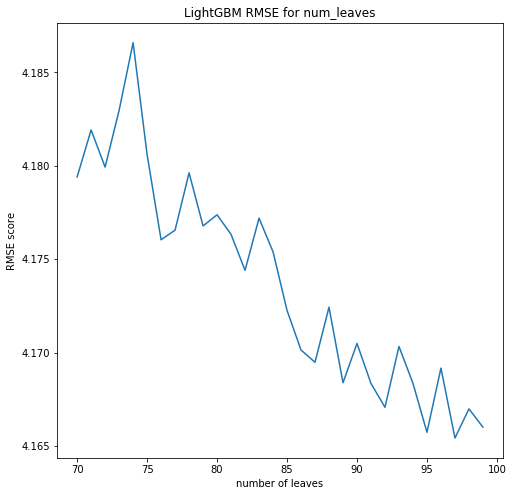

In [21]:
# Cursory search for num_leaves hyperparameter
num_leaves_score = []
for i in range(70,100):
    cv_results = cross_validate(LGBMRegressor(num_leaves= i, random_state = 100), 
                                X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 3)
    num_leaves_score.append(-sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(range(70,100), num_leaves_score)
plt.title('LightGBM RMSE for num_leaves')
plt.xlabel('number of leaves')
plt.ylabel('RMSE score')
plt.show()
fig.savefig('LGBM-num_leaves_new.pdf')
plt.close()

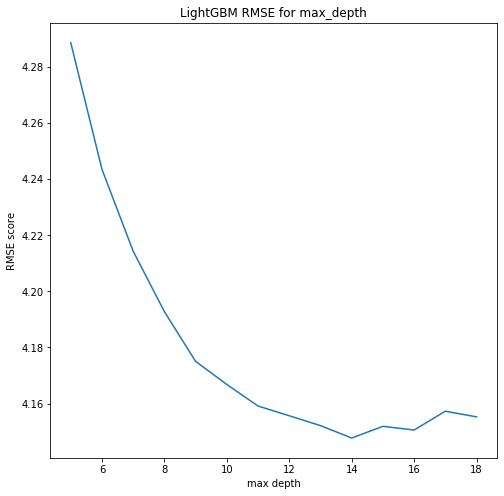

In [22]:
# Cursory search for max_depth hyperparameter
max_depth_score = []
for i in range(5, 30):
    cv_results = cross_validate(LGBMRegressor(max_depth= i, num_leaves = int(pow(2, i)/2), random_state = 100), 
                                X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 3)
    max_depth_score.append(-sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(range(5,30), max_depth_score)
plt.title('LightGBM RMSE for max_depth')
plt.xlabel('max depth')
plt.ylabel('RMSE score')
plt.show()
fig.savefig('LGBM-max_depth_new.pdf')
plt.close()

In [23]:
# LGBM regressor tuning 
def lgbm_func(max_depth,num_leaves):
    cv_results = cross_validate(LGBMRegressor(max_depth = int(max_depth), 
                                              num_leaves = int(num_leaves),
                                              random_state= 100),
                                X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 3)
    return sum(cv_results['test_score']) / len(cv_results['test_score'])


# Find the global maximum of the target function 
lgbm_params = BayesianOptimization(lgbm_func, {'max_depth': (13,17), 'num_leaves': (90, 100)}, random_state = 100)
lgbm_params.maximize(n_iter = 10, init_points = 2)
final_para_lgbm = lgbm_params.max
lgbm_params.max

|   iter    |  target   | max_depth | num_le... |
-------------------------------------------------
|  1        | -4.168    |  15.17    |  92.78    |
|  2        | -4.167    |  14.7     |  98.45    |
|  3        | -4.167    |  14.68    |  98.47    |
|  4        | -4.16     |  17.0     |  100.0    |
|  5        | -4.162    |  17.0     |  98.73    |
|  6        | -4.17     |  13.0     |  90.0     |
|  7        | -4.166    |  16.23    |  100.0    |
|  8        | -4.164    |  17.0     |  99.46    |
|  9        | -4.16     |  16.98    |  99.97    |
|  10       | -4.162    |  17.0     |  98.04    |
|  11       | -4.164    |  15.34    |  99.44    |
|  12       | -4.161    |  16.32    |  98.37    |


{'target': -4.160410846317948,
 'params': {'max_depth': 16.98324209658358, 'num_leaves': 99.97405438037804}}

In [24]:
depth = int(final_para_lgbm['params']['max_depth'])
leaves = int(final_para_lgbm['params']['num_leaves'])

lgbm_model = LGBMRegressor(max_depth= depth,num_leaves = leaves,random_state= 100)
lgbm_model.fit(X_train, y_train)

pred = lgbm_model.predict(X_test)
print("max-depth: " + str(depth))
print("num_leaves: "+str(leaves))
lgbm_rmse = np.sqrt(mean_squared_error(y_test, pred))
print("RMSE: " + str(lgbm_rmse))

max-depth: 16
num_leaves: 99
RMSE: 4.071771630523179


In [25]:
features = list(X.columns)
importance = list(lgbm_model.feature_importances_)
importance_dict = {}
for i in range(len(features)):
    importance_dict[features[i]] = importance[i]
sorted(importance_dict.items(), key = lambda item: abs(item[1]), reverse = True)

[('store_number', 2543),
 ('item_number', 2076),
 ('category', 989),
 ('encoded_city', 745),
 ('retail_price', 734),
 ('population', 674),
 ('cost_price', 621),
 ('county_number', 436),
 ('bottle_volume', 362),
 ('week_of_day', 271),
 ('pack', 186),
 ('store_num', 163)]

## Result of RMSE

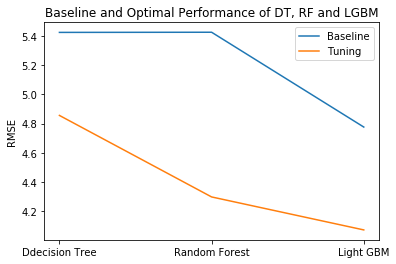

In [26]:
baseline = [dt_base_rmse, rf_base_rmse, lgbm_base_rmse]
tuning = [dt_rmse, rf_rmse, lgbm_rmse]
model = ["Ddecision Tree", "Random Forest", "Light GBM"]
fig, ax = plt.subplots()
plt.title("Baseline and Optimal Performance of DT, RF and LGBM")
plt.ylabel("RMSE")
plt.plot(model, baseline, label = 'Baseline')
plt.plot(model, tuning, label = 'Tuning')
plt.legend(loc = 'upper right')
plt.show()
fig.savefig('RMSE for three models.pdf')